In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

2023-04-03 06:57:43.277519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set of constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=30
EPOCHS=25

## Importing the Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FIDS30",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 971 files belonging to 30 classes.


2023-04-03 06:57:52.255402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 06:57:52.258792: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
class_names = dataset.class_names
print(len(class_names))
class_names

30


['acerolas',
 'apples',
 'apricots',
 'avocados',
 'bananas',
 'blackberries',
 'blueberries',
 'cantaloupes',
 'cherries',
 'coconuts',
 'figs',
 'grapefruits',
 'grapes',
 'guava',
 'kiwifruit',
 'lemons',
 'limes',
 'mangos',
 'olives',
 'oranges',
 'passionfruit',
 'peaches',
 'pears',
 'pineapples',
 'plums',
 'pomegranates',
 'raspberries',
 'strawberries',
 'tomatoes',
 'watermelons']

## Preprocess the Dataset

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 5 11 27 21 24 19  3 22  6 14 11 19 17 24 11 21 22 12 21 17  4 22  5 25
  1  8 25  6  4 21 23 18]


2023-04-03 06:58:38.193687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 256
2023-04-03 06:58:38.196228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2 of 256
2023-04-03 06:58:38.196354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3 of 256
2023-04-03 06:58:44.888568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 67 of 256
2023-04-03 06:58:54.967125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 91 of 256
2023-04-03 06:58:58.583669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


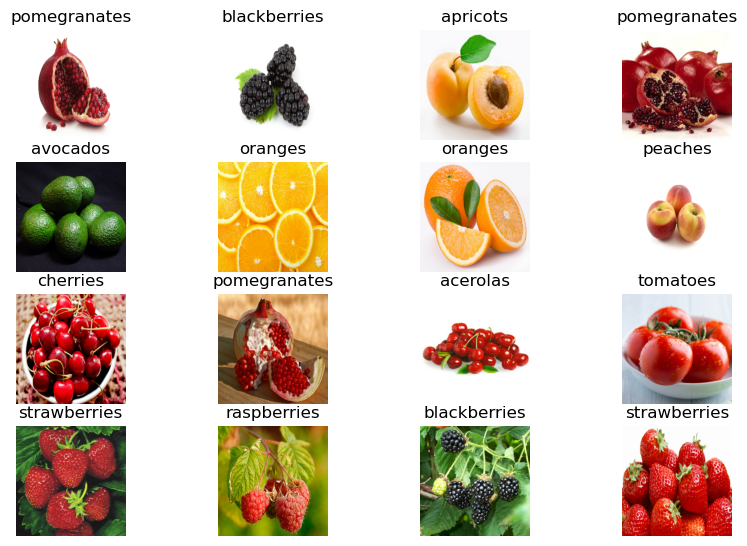

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(6, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


#### Splitting the dataset

In [7]:
len(dataset)

31

In [8]:
train_size = 0.8
len(dataset)*train_size

24.8

In [9]:
train_ds = dataset.take(24)
test_ds = dataset.skip(24)

In [10]:
val_size=0.1
len(dataset)*val_size

3.1

In [11]:
val_ds = test_ds.take(3)
test_ds = test_ds.skip(3)

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
print("train_ds", len(train_ds))
print("val_ds ", len(val_ds))
print("test_ds ", len(test_ds))

train_ds 24
val_ds  3
test_ds  4


## Shuffling Data

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Model Architecture

In [19]:
num_classes = 30

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/25


2023-04-03 06:59:10.648054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 06:59:15.883820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 06:59:17.395198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 21 of 10000
2023-04-03 06:59:17.441062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 06:59:17.924411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-04-03 06:59:17.924549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-04-03 06:59:17.924745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


24/24 [==============================] - ETA: 0s - loss: 3.3005 - accuracy: 0.0716

2023-04-03 07:01:13.567818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 07:01:18.633876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 07:01:19.616453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 20 of 10000
2023-04-03 07:01:19.931109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 07:01:20.224561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-04-03 07:01:20.224823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-04-03 07:01:20.224930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


24/24 [==============================] - 144s 6s/step - loss: 3.3005 - accuracy: 0.0716 - val_loss: 3.0297 - val_accuracy: 0.0521
Epoch 2/25
24/24 [==============================] - 114s 5s/step - loss: 2.8008 - accuracy: 0.1589 - val_loss: 2.5404 - val_accuracy: 0.1979
Epoch 3/25
24/24 [==============================] - 107s 4s/step - loss: 2.3434 - accuracy: 0.2539 - val_loss: 2.1912 - val_accuracy: 0.3229
Epoch 4/25
24/24 [==============================] - 91s 4s/step - loss: 2.0171 - accuracy: 0.3529 - val_loss: 1.8688 - val_accuracy: 0.4271
Epoch 5/25
24/24 [==============================] - 93s 4s/step - loss: 1.8339 - accuracy: 0.4193 - val_loss: 1.6813 - val_accuracy: 0.4896
Epoch 6/25
24/24 [==============================] - 93s 4s/step - loss: 1.6351 - accuracy: 0.4740 - val_loss: 1.3501 - val_accuracy: 0.5833
Epoch 7/25
24/24 [==============================] - 94s 4s/step - loss: 1.5175 - accuracy: 0.5169 - val_loss: 1.5170 - val_accuracy: 0.4792
Epoch 8/25
24/24 [==========

In [22]:
scores = model.evaluate(test_ds)

2023-04-03 07:42:49.948543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 07:42:55.035881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 10000
2023-04-03 07:42:55.421676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 07:42:56.818114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-03 07:42:57.148190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-04-03 07:42:57.148287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-04-03 07:42:57.148378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


4/4 [==============================] - 16s 992ms/step - loss: 0.6097 - accuracy: 0.8594


### Evaluation

In [23]:
# Scores is just a list containing loss and accuracy value
scores

[0.6097284555435181, 0.859375]

### Saving the Model

In [24]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2/assets


INFO:tensorflow:Assets written to: ./models/2/assets
